# Objective: Create a model to predict whether a customer will churn

**We will use this dataset: (https://www.kaggle.com/datasets/blastchar/telco-customer-churn)** 

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb


In [44]:
import warnings
warnings.simplefilter(action='ignore')

### 1st Step: Loading the data and first look

In [2]:
df = pd.read_csv(r"C:\Users\konch\Downloads\Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [4]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


### 2nd Step: EDA

In [5]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Text(0.5, 1.0, 'Ratio of Churn to No-Churn')

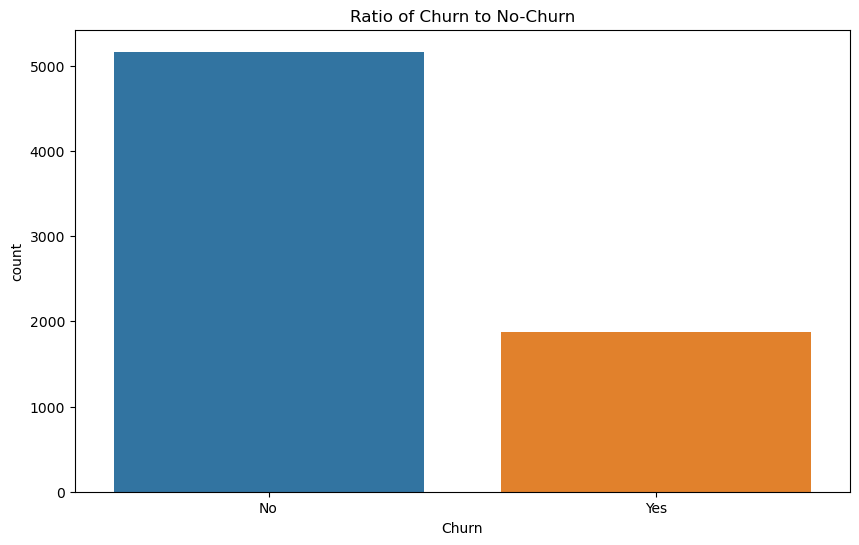

In [6]:
plt.figure(figsize=(10,6))
sns.countplot(x=df['Churn'])
plt.title('Ratio of Churn to No-Churn')

First Impression: Model is pretty imbalanced and will need to use a sampling technique to balance it later

In [7]:
df_dum = pd.get_dummies(df, columns=['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 
     'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'InternetService',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'], drop_first= True)

In [8]:
df_dum = df_dum.drop('customerID', axis=1)

In [9]:
df_dum.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,1,29.85,29.85,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,34,56.95,1889.50,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,2,53.85,108.15,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,1
3,45,42.30,1840.75,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,2,70.70,151.65,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1


In [10]:
corr = df_dum.corr()[['Churn_Yes']].sort_values(by='Churn_Yes', ascending=False)

<AxesSubplot:>

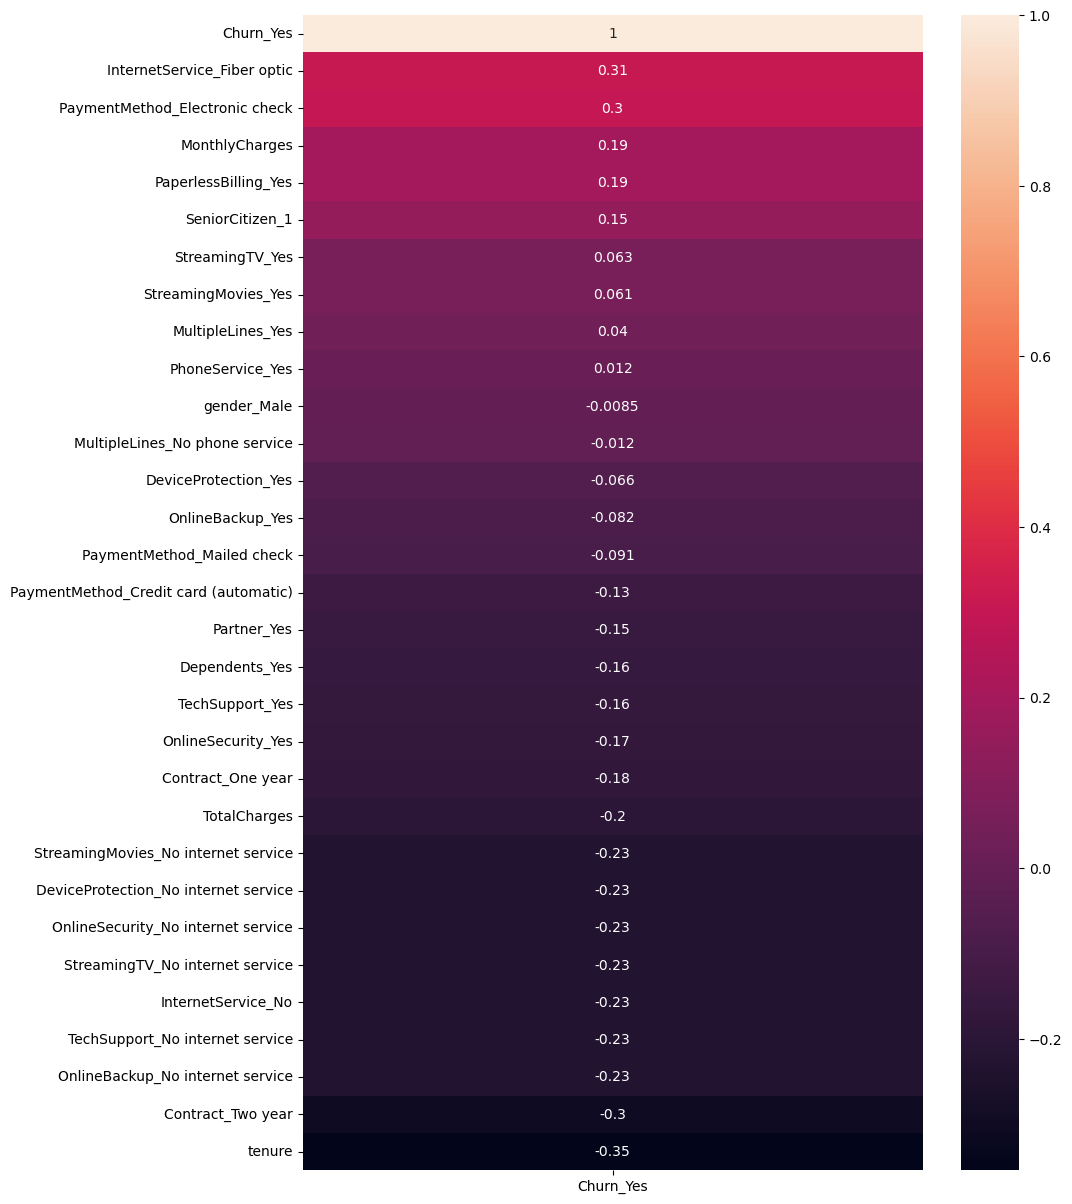

In [11]:
plt.figure(figsize=(10,15))
sns.heatmap(corr, annot=True)

<AxesSubplot:xlabel='MonthlyCharges', ylabel='TotalCharges'>

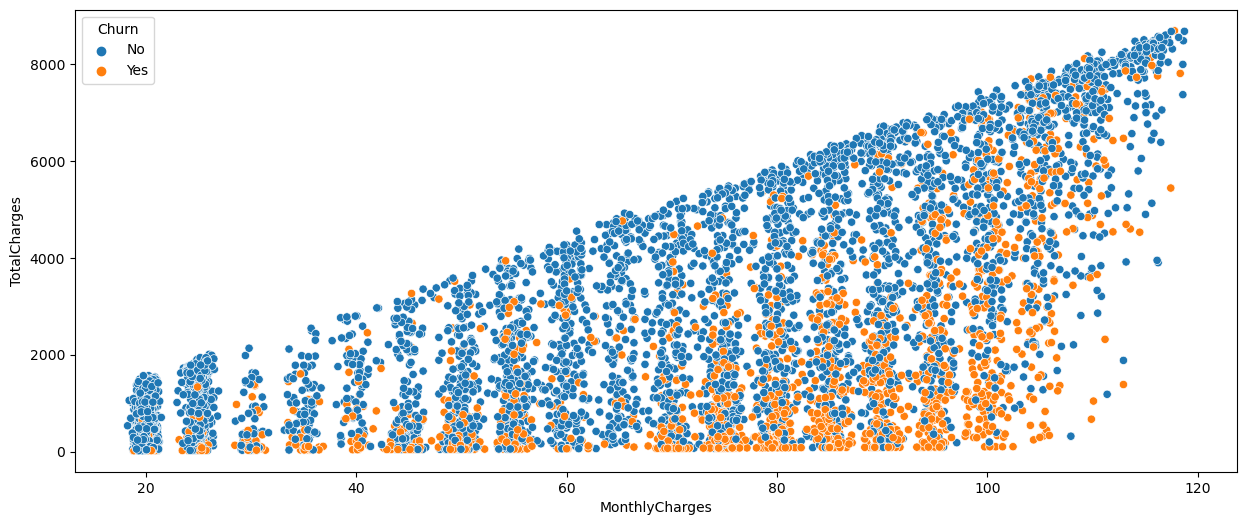

In [12]:
plt.figure(figsize=(15,6))
sns.scatterplot(data=df,x= 'MonthlyCharges',y='TotalCharges',hue='Churn')

Findings: We can see that customers who churn are across the entire spectrum of monthly charges but tend to be overrepresented in the lower ends ot total charges. Meaning that they churn fast, before the total charges stack up. This could be a problem for the Marketing Dept as it could indicate that the company is having difficulty creating value and loyalty to new customers.

So far we are seeing that the average churner usually churns relatively fast, and has little interaction with the brand and the product mix. It makes sense to further investigate by dividing the customer base in groups based on the time they spend as customers ('tenure' in Dataset).

## Step 3: Grouping by Tenure

In [13]:
churn_rates = df_dum.groupby('tenure')['Churn_Yes'].mean().round(4) * 100
df_dum['churn_rate'] = df_dum.groupby('tenure')['Churn_Yes'].transform('mean').round(4) * 100
churn_rates.sort_values(ascending=False) 

tenure
1     61.99
2     51.68
5     48.12
4     47.16
3     47.00
      ...  
62     7.14
63     5.56
64     5.00
71     3.53
72     1.66
Name: Churn_Yes, Length: 72, dtype: float64

In [14]:
df_dum['churn_rate'] 

0       61.99
1       18.46
2       51.68
3        9.84
4       51.68
        ...  
7027    24.47
7028     1.66
7029    31.31
7030    47.16
7031    14.61
Name: churn_rate, Length: 7032, dtype: float64

Text(0.5, 1.0, 'Churn Rate over time')

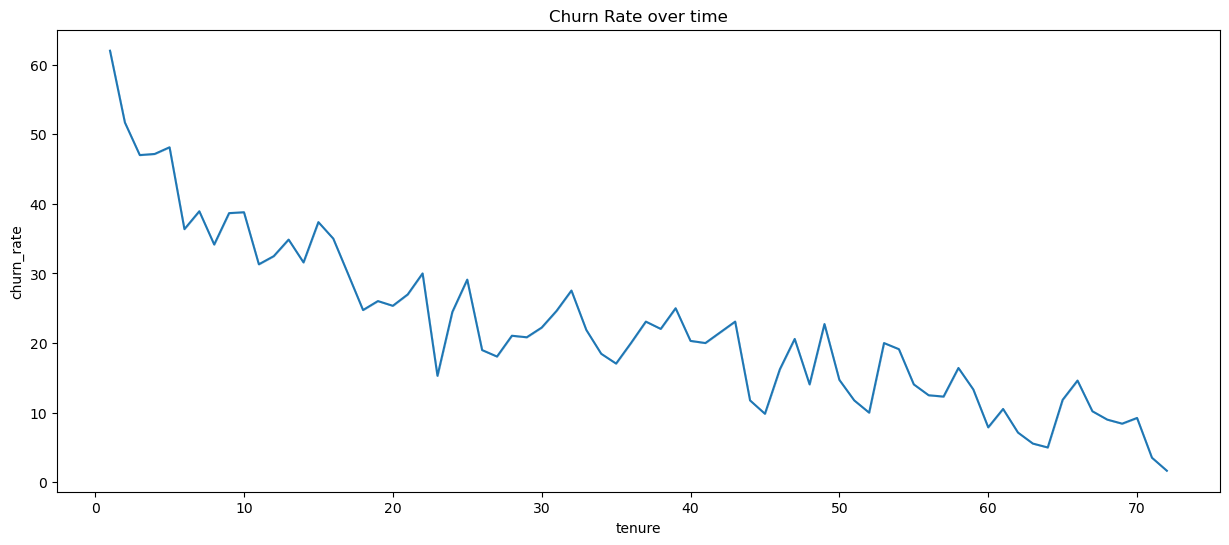

In [15]:
plt.figure(figsize=(15,6))
sns.lineplot(data=df_dum,x='tenure',y='churn_rate')
plt.title('Churn Rate over time')

In [16]:
def funct(x) :
    if x <= 12:
        return '1 - 12 months'
    elif x <= 24:
        return '12 - 24 months'
    elif x <= 48:
        return '24 - 48 months'
    else:
        return '48+ months'

In [17]:
df_dum['Cohort'] = df_dum['tenure'].apply(funct)

In [18]:
df_dum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 33 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tenure                                 7032 non-null   int64  
 1   MonthlyCharges                         7032 non-null   float64
 2   TotalCharges                           7032 non-null   float64
 3   gender_Male                            7032 non-null   uint8  
 4   SeniorCitizen_1                        7032 non-null   uint8  
 5   Partner_Yes                            7032 non-null   uint8  
 6   Dependents_Yes                         7032 non-null   uint8  
 7   PhoneService_Yes                       7032 non-null   uint8  
 8   MultipleLines_No phone service         7032 non-null   uint8  
 9   MultipleLines_Yes                      7032 non-null   uint8  
 10  OnlineSecurity_No internet service     7032 non-null   uint8  
 11  Onli

Text(0.5, 1.0, 'Churn rate per Cohort')

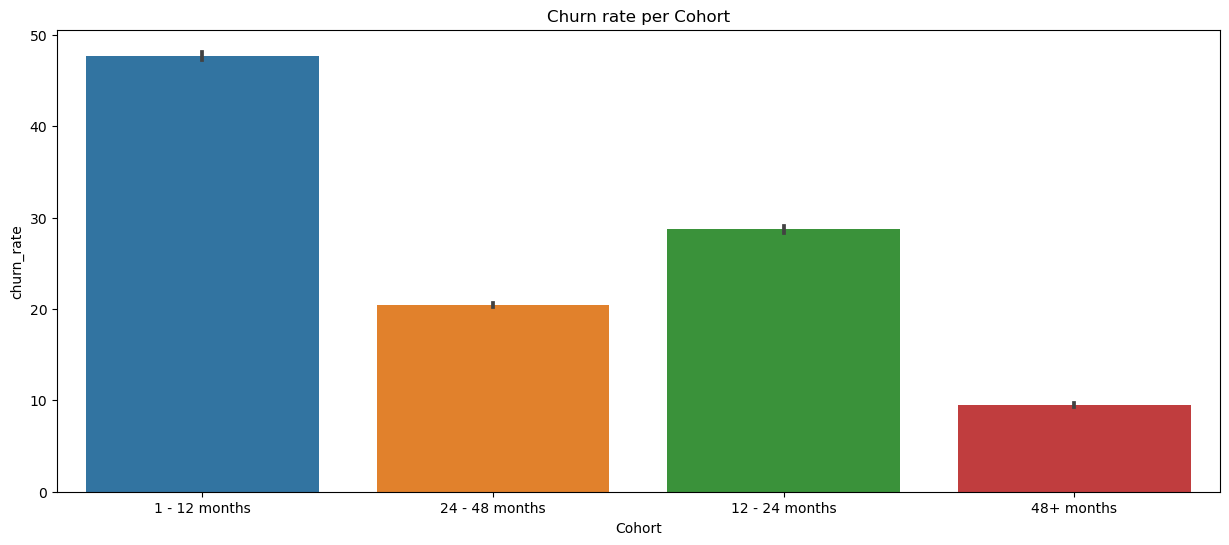

In [19]:
plt.figure(figsize=(15,6))
sns.barplot(data= df_dum,x='Cohort', y='churn_rate')
plt.title('Churn rate per Cohort')

## Step 4: Training the models and using SMOTE to balance the sample

In [20]:
df_test = df_dum.drop('Cohort', axis = 1)

In [21]:
X = df_test.drop(['Churn_Yes'], axis = 1)
y = df_test['Churn_Yes']

In [22]:
su = SMOTE(random_state=42)
X, y = su.fit_resample(X, y)

# Smote helped up the accuracy metrics significantly regardless of algorithm (from 60%ish average to 85% across the board)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state= 101)

### Logistic regression

In [24]:
logreg = LogisticRegression(max_iter= 10e5)


In [25]:
param_grid = {
    'solver': ['saga', 'liblinear','lbfgs'],
    'C' : [1.0, 1.4, 1.2],
    }

In [26]:
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best Parameters for Logistic Regression: {best_params}')

Best Parameters: {'C': 1.4, 'solver': 'liblinear'}


In [27]:
logreg = LogisticRegression(max_iter= 10e5, **best_params)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.4, max_iter=1000000.0, solver='liblinear')

In [28]:
y_log_pred = logreg.predict(X_test)

In [29]:
print(classification_report(y_test, y_log_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1030
           1       0.83      0.86      0.84      1036

    accuracy                           0.84      2066
   macro avg       0.84      0.84      0.84      2066
weighted avg       0.84      0.84      0.84      2066



In [56]:
cv_scores = cross_val_score(logreg, X_train, y_train, cv=3, scoring='accuracy')

In [69]:
print("Cross Validation Scores for LR:", cv_scores.round(3))
print("Mean CV Score for LR:", cv_scores.mean().round(3))

Cross Validation Scores for LR: [0.83  0.826 0.835]
Mean CV Score for LR: 0.831


## KNN

In [75]:
kmodel = KNeighborsClassifier()

In [76]:
param_grid = {
    'n_neighbors':[ 3, 4, 5],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree'],
    'p': [1,2]}

In [77]:
grid_search = GridSearchCV(estimator=kmodel, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best Parameters for KNN: {best_params}')

Best Parameters for KNN: {'algorithm': 'ball_tree', 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}


In [78]:
kmodel = KNeighborsClassifier(**best_params)
kmodel.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=4, p=1,
                     weights='distance')

In [81]:
y_knn = kmodel.predict(X_test)

In [82]:
print(classification_report(y_test, y_knn))

              precision    recall  f1-score   support

           0       0.89      0.71      0.79      1030
           1       0.76      0.91      0.83      1036

    accuracy                           0.81      2066
   macro avg       0.82      0.81      0.81      2066
weighted avg       0.82      0.81      0.81      2066



In [85]:
cv_scores_km = cross_val_score(kmodel, X_train, y_train, cv=3, scoring='accuracy')

In [86]:
print("Cross Validation Scores for KNN:", cv_scores_km.round(3))
print("Mean CV Score for KNN:", cv_scores_km.mean().round(3))

Cross Validation Scores for KNN: [0.791 0.802 0.791]
Mean CV Score for KNN: 0.795


## Random Forest

In [30]:
rfc = RandomForestClassifier(random_state=101)



In [31]:
param_grid = {
    'warm_start': [True, False],
    'n_estimators': [100, 200, 300]}

In [32]:
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best Parameters: {best_params}')

Best Parameters: {'n_estimators': 300, 'warm_start': True}


In [33]:
best_params

{'n_estimators': 300, 'warm_start': True}

In [34]:
rfc = RandomForestClassifier(random_state=101,**best_params)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, random_state=101, warm_start=True)

In [35]:
y_rfc = rfc.predict(X_test)

In [36]:
print(classification_report(y_test, y_rfc))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      1030
           1       0.85      0.86      0.86      1036

    accuracy                           0.85      2066
   macro avg       0.85      0.85      0.85      2066
weighted avg       0.85      0.85      0.85      2066



In [59]:
cv_scores_rf = cross_val_score(rfc, X_train, y_train, cv=3, scoring='accuracy')

In [87]:
print("Cross Validation Scores Random Forest:", cv_scores_rf.round(3))
print("Mean CV Score Random Forest:", cv_scores_rf.mean().round(3))

Cross Validation Scores Random Forest: [0.83660131 0.83581547 0.83654195]
Mean CV Score Random Forest: 0.836


## XGBoost

In [37]:
xgbmodel = xgb.XGBClassifier()


In [48]:
param_grid = {
    'max_depth': [4, 5 ,6],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

In [ ]:
grid_search = GridSearchCV(estimator=xgbmodel, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best Parameters: {best_params}')

In [40]:
xgbmodel = xgb.XGBClassifier(**best_params)
xgbmodel.fit(X_train, y_train)

[17:05:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [41]:
yxgb = xgbmodel.predict(X_test)

In [42]:
print(classification_report(y_test, yxgb))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1030
           1       0.85      0.86      0.85      1036

    accuracy                           0.85      2066
   macro avg       0.85      0.85      0.85      2066
weighted avg       0.85      0.85      0.85      2066



In [63]:
cv_scores_xgb = cross_val_score(xgbmodel, X_train, y_train, cv=3, scoring='accuracy')

[17:58:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:58:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:58:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [88]:
print("Cross Validation Scores XGBoost:", cv_scores_xgb.round(3))
print("Mean CV Score XGBoost :", cv_scores_xgb.mean().round(3))

Cross Validation Scores XGBoost: [0.837 0.836 0.842]
Mean CV Score XGBoost : 0.838


### Best Mean CV Score was achieved with XGBoost Algortihm followed very closely by Random Forest. We could stick to the XGBoost Algortihm for the miniscule added accuracy but the Random Forest is easier to implement and explain, so I think I would opt for the Random Forest Model.